# **SW10: Linear discriminant analysis (LDA)**

The linear discriminant method combines dimensionality reduction
with classification: In the case of two classes, its aim is to reduce the 
classification problem *from D feature space dimensions to 1 dimension*. 
The projection of the data points onto this dimension is chosen such that
the separation of the classes is maximized. Using this 1D representation, we 
can then classify new data points. The better the separation of the classes 
in the reduced feature space, the easier the classification.

![Arbitrary vs. LDA projection](../data/images/lda-bishop-extended.webp)

<span style="font-size:small;">***Figure 1**: 
Two projections from 2D onto a 1D subspace. The green lines show the direction 
of projection. The histogram summarizes how the samples (blue and red dots) are 
projected onto this sub-space. The second projection is more favorable to ensure 
a good separation between the two classes (blue and red dots). Maximizing the gap 
between the centroids alone (left figure) is not sufficient. Considering the 
scatter (as in Fisher’s method, right figure) improves separability. 
(Illustration from Bishop, Pattern recognition and Machine 
Learning, 2006, section 4.1.4., adapted version from Prachi Singh.)*
</span> 



The basic form (also known as Fisher's linear discriminant) is limited to a
two-class classification problem: *D*-dimensional data is projected onto a
line (i.e., a one-dimensional subspace). This basic form can be extended to
multi-class classification problems. Here, the data is projected onto a subspace 
with maximally C-1 dimensions, where C is the number of classes. The scikit-learn 
implementation of the generalized linear discriminant method is called 
[LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

Because the method requires labeled data for training, the method is considered
a *supervised learning method*.

In this notebook we try to understand how the linear discriminant method works. 
To get a feel for the method, I highly recommend reading [this interactive article](https://omarshehata.github.io/lda-explorable/) by Omar Shehata. 

### **Further reading / watching**:
- StatQuest: Linear Discriminant Analysis (LDA) clearly explained. [YouTube](https://www.youtube.com/watch?v=azXCzI57Yfc)
- A Geometric Intuition for Linear Discriminant Analysis, by Omar Shehata. A beautifully interactive article. [Link](https://omarshehata.github.io/lda-explorable/)
- Section 4.1.4 "Fisher’s linear discriminant" in the book Pattern Recognition and Machine 
  Learning by Christopher Bishop (2006). [Link](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)
- Linear Discriminant Analysis, by Sebastian Raschka. [Link](https://sebastianraschka.com/Articles/2014_python_lda.html)







---

## **Setup**



In [1]:
# Basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Some Jupyter magic for nicer output
%config InlineBackend.figure_formats = ["svg"]   # Enable vectorized graphics

# Adjust the default settings for plots
import sys
sys.path.append("..")
import ml
ml.setup_plotting()

---

## **Data preparation**

The [make_blobs()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) 
function from scikit-learn generates random data points for a specified number 
of clusters. The data points are normally distributed around the cluster 
centers with a specified standard deviation. We then further stretch the data 
points to create elongated clusters.

In [2]:
n_samples = 500     # Number of samples to generate
seed = 42           # Set to None to generate different data each time

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=n_samples, 
                  centers=3, 
                  cluster_std=[1.0, 2.0, 4], 
                  random_state=seed)

def stretch_data(X, mask, T):
    mu = X[mask].mean(axis=0)
    X[mask] = (X[mask] - mu) @ T + mu
    return X

# Stretch the clusters in different directions
X = stretch_data(X, y==0, np.array([[2,0.5],[0, 1]]))
X = stretch_data(X, y==1, np.array([[1,-0.5],[0.5, 1]]))

# Make the data imbalanced
# mask0 = y==0
# mask1 = y==1
# mask1[50:] = False
# X = X[mask0 | mask1]
# y = y[mask0 | mask1]

# Collect the data in a DataFrame, just in case
data = pd.DataFrame(X, columns=["Feature 1", "Feature 2"])
data["Target"] = y

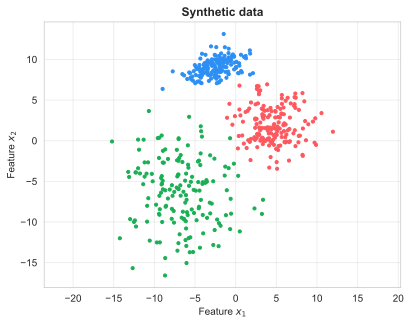

In [3]:
# Visualize the data
plt.scatter(X[:,0], X[:,1], cmap=ml.PALETTE_CMAP, c=y, s=10, alpha=1., )
plt.xlabel("Feature $x_1$")
plt.ylabel("Feature $x_2$")
plt.title("Synthetic data", fontweight="bold")
plt.axis("equal")
plt.show()

## **Apply LDA**

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Fit the model
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# Predict the labels
y_pred = lda.predict(X)
scores = lda.decision_function(X)
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

# The model parameters
w = lda.coef_[0]
b = lda.intercept_[0]

Accuracy: 0.984


**That's all we need to do to compute the linear discriminant analysis
with scikit-learn!** 😊 

The coefficients *w* of the model (stored in lda.coef_) describe the 
direction of the linear decision boundary. The vector *w* has the same
dimensionality as the input data, and is orthogonal to the decision boundary.
The intercept *b* (stored in lda.intercept_) is the offset of the decision
function from the origin. It is set such that the decision function has a
negative value for samples from the first class, and a positive value for
samples from the second class. For our 2D problem, the linear decision function 
is given by:
  $$score(x_1, x_2|w,q) = w_1x_1 + w_2x_2 + b$$
To find the decision boundary, we can set $score(x)=0$ and solve for $x_2$:
  $$x_2 = -\frac{w_1}{w_2} x_1 - \frac{b}{w_1}$$

The code below is just for visualization (you don't need to understand that code!).

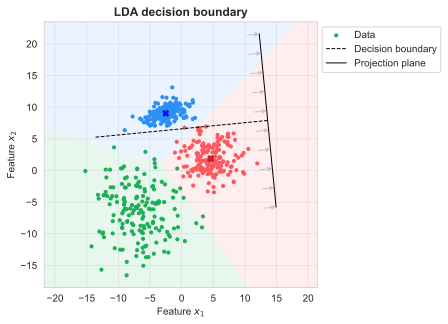

In [5]:
def plot_lda(lda, X, y, w, b):
    """Plot the data and the decision boundary of the LDA model.
    You DON'T have to understand the details of this function. :)
    """  
    # Decision boundary
    # pC_db is the intersection of the decision boundary with the 
    # line connecting the means, serving as a reference point.
    from ml.maths import intersect_line_with_segment
    pC_db = intersect_line_with_segment(m=-w[0]/w[1], 
                                    q=-b/w[1], 
                                    p1=lda.means_[0], 
                                    p2=lda.means_[1], 
                                    extend=True)
    v_db = np.array([-w[1], w[0]])
    v_db = v_db / np.linalg.norm(v_db)
    spread = max(X[:,0].std(), X[:,1].std())
    p0_db = pC_db - 2*spread*v_db
    p1_db = pC_db + 2*spread*v_db

    # Projection plane (don't worry, if you don't understand this)
    # The goal is here to draw the line at a suitable position.
    p0_pl = p0_db - 2*spread*w/np.linalg.norm(w)
    p1_pl = p0_db + 2*spread*w/np.linalg.norm(w)

    fig, ax = plt.subplots()
    # Plot the data
    ax.scatter(X[:,0], X[:,1], c=y, s=10, 
               cmap=ml.PALETTE_CMAP,
               alpha=1., label="Data")
    # Plot the means
    ax.scatter(lda.means_[0][0], lda.means_[0][1], s=40, marker="X", 
               color="blue", edgecolor="darkblue", linewidth=0.5)
    ax.scatter(lda.means_[1][0], lda.means_[1][1], s=40, marker="X",
               color="crimson", edgecolor="darkred", linewidth=0.5)
    # Quiver plot of the LDA coefficients
    du = 2*w[1]/np.linalg.norm(w)
    dv = -2*w[0]/np.linalg.norm(w)
    x0_qv = np.linspace(p0_pl[0], p1_pl[0], 10) - du
    x1_qv = np.linspace(p0_pl[1], p1_pl[1], 10) - dv
    ax.quiver(x0_qv, x1_qv, du, dv, 
              color="black", scale=1, scale_units="xy", angles="xy", 
              units="dots", width=1, headwidth=5, alpha=0.2,)
    # Plot the decision boundary
    ax.plot([p0_db[0], p1_db[0]], [p0_db[1], p1_db[1]], 
            color="black", linestyle="--", linewidth=1, 
            label="Decision boundary")
    # Projection plane / line
    ax.plot([p0_pl[0], p1_pl[0]], [p0_pl[1], p1_pl[1]], 
            color="black", linestyle="-", linewidth=1,
            label="Projection plane")
    # Plot the decision regions
    ax.axis("scaled")
    ax.set_xlim(ax.get_xlim()[0]-5, ax.get_xlim()[1]+5)
    xx0 = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 200)
    xx1 = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 200)
    XX0, XX1 = np.meshgrid(xx0, xx1)
    XX = np.c_[XX0.ravel(), XX1.ravel()]
    YY = lda.predict(XX).reshape(XX0.shape)
    ax.contourf(XX0, XX1, YY, cmap=ml.PALETTE_CMAP, alpha=0.1)
    # Labels and legends
    ax.set_xlabel("Feature $x_1$")
    ax.set_ylabel("Feature $x_2$")
    ax.set_title("LDA decision boundary", fontweight="bold")
    # Legend outside the plot, top right
    ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
    plt.show()

plot_lda(lda, X, y, w, b)

We also visualize how the points are distributed in the 1D space 
after the projection. As a matter of fact, this is equivalent to 
the decision function (up to some scaling).

In [6]:
# Plot the LDA scores as histogram
scores = lda.decision_function(X)
sns.histplot(x=scores, hue=y, bins=30, kde=True)
plt.xlabel("LDA score")
plt.ylabel("Frequency")
plt.title("LDA scores: $decision\_function(X)$", fontweight="bold")
plt.show()

# This corresponds to the decision function
scores_ = w @ X.T + b
assert np.allclose(scores, scores_)

# Plot the LDA scores as histogram
sns.histplot(x=scores_, hue=y, bins=30, kde=True)
plt.xlabel("LDA score")
plt.ylabel("Frequency")
plt.title("LDA scores: $y = w^Tx + b$", fontweight="bold")
plt.show()


ValueError: Per-column arrays must each be 1-dimensional

---

## **Appendix A: Covariance matrix $^*$**

<span style="color:lightgray;">Just for the curious students...</span> 

Do you recall the covariance matrix? For a dataset with D features, the
covariance matrix is a D×D matrix. For example, if our data has N samples and 
3 variables
$X = [x_1, x_2, x_3] \in \mathbb{R}^{N\times 3}$:

$$ Cov(X) = \left[\begin{array}{ccc}
\operatorname{var}(x_1) & \operatorname{cov}(x_1, x_2) & \operatorname{cov}(x_1, x_3) \\
\operatorname{cov}(x_1, x_2) & \operatorname{var}(x_2) & \operatorname{cov}(x_2, x_3) \\
\operatorname{cov}(x_1, x_3) & \operatorname{cov}(x_2, x_3) & \operatorname{var}(x_3)
\end{array}\right]$$

In the diagonal of the matrix, we have the variance of each feature that 
measures how much the data is spread along that axis. The off-diagonal elements 
are the covariance between the features. The covariance is a measure of how much
two variables change together. If the covariance is positive, the variables 
increase together. If the covariance is negative, one variable increases while 
the other decreases. If the covariance is zero, the variables are uncorrelated.

In Python, we have several possibilities to calculate the covariance matrix.
Of course, NumPy offers a function for that: 
[np.cov()](https://numpy.org/doc/stable/reference/generated/numpy.cov.html)

Note that the function np.cov() expects a data matrix that is transposed 
to the format we are used to. That is, the rows are the features, and the
columns are the samples.

However, we can also compute the covariance matrix using a mathematical 
expression. Do you remember how we can estimate the variance of a random 
variable $x$? Right, we can use the following formula!

$$\text{var}(x) = \frac{1}{N-1} \sum_{i=1}^{N} (x_i - \mu_x)^2$$

Similarly, the covariance between two random variables $x$ and $y$ can be estimated as follows:

$$\text{cov}(x, y) = \frac{1}{N-1} \sum_{i=1}^{N} (x_i - \mu_x)(y_i - \mu_y)$$

If you twist your head a bit, and if you familiarize yourself with matrix 
multiplication, you can appreciate that the covariance matrix can be 
computed using the following rather simple formula:

$$\begin{align*}Z &= X - \mu_X\\ 
\text{Cov}(X) &= \frac{1}{N-1} Z^T \cdot Z
\end{align*}$$

Here, $Z$ is the centered data matrix, and $\mu_X$ is the (column-wise) mean of the data matrix $X$. The expression $Z^TZ$ (i.e., the multiplication of the transposed version of $Z^T with $Z$) is sometimes referred to as *scatter matrix*

Hence, the following two Python expressions are equivalent!

In [7]:
cov_numpy = np.cov(X.T)

Z = X - X.mean(axis=0)
cov_formula = Z.T @ Z / (len(X) - 1)

print("Covariance matrix (numpy):")
print(cov_numpy)

print("\nCovariance matrix (formula):")
print(cov_formula)

Covariance matrix (numpy):
[[28.88574391 11.55344709]
 [11.55344709 47.24704475]]

Covariance matrix (formula):
[[28.88574391 11.55344709]
 [11.55344709 47.24704475]]


---

## **Appendix B: Some maths related to LDA $^*$**

<span style="color:lightgray;">Again, just for the curious students...</span> 

In the above code, we used the LinearDiscriminantAnalysis class from 
scikit-learn to fit a linear discriminant model to the data. We actually
can compute the result explicitly using the covariance matrices and means.


In [8]:
# Compute the LDA using scikit-learn
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# We can retrieve the projection vector w and the threshold from the model
w_sklearn = lda.coef_[0].copy()
b_sklearn = lda.intercept_[0].copy()

# But we can also compute them manually
cov = np.cov(X.T)
mu0 = X[y==0].mean(axis=0)
mu1 = X[y==1].mean(axis=0)

# This is the formula from the lecture slides:
# w = cov^(-1) @ (mu1 - mu0)...
w_manual = np.linalg.inv(cov) @ (mu1 - mu0)
b_manual = 0.5 * (mu0 @ np.linalg.inv(cov) @ mu0 - mu1 @ np.linalg.inv(cov) @ mu1)

# Well, to actually see the equivalence, we need to scale the vectors to have
# the same length. We can do this by dividing the vectors by their length. 
# The threshold needs to be scaled accordingly.
w_sklearn_len = np.linalg.norm(w_sklearn)
w_sklearn /= w_sklearn_len
b_sklearn /= w_sklearn_len

w_manual_len = np.linalg.norm(w_manual)
w_manual /= w_manual_len
b_manual /= w_manual_len

print("Projection vector (scikit-learn):", w_sklearn)
print("Projection vector (manual):      ", w_manual)
print("Threshold (scikit-learn):        ", b_sklearn)
print("Threshold (manual):              ", b_manual)



Projection vector (scikit-learn): [-0.09667865  0.99531565]
Projection vector (manual):       [ 0.8231304 -0.5678524]
Threshold (scikit-learn):         -6.552796073532551
Threshold (manual):               2.2479893178739045
